## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib

# from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.utils.franka import reconstruct_actions
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2024-08-16 16:08:46.198 | INFO     |  Running on cuda:0


In [3]:
task = 'Cabinet'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)


2024-08-16 16:08:47.134 | INFO     |  Loading dataset(s): 
2024-08-16 16:08:47.135 | INFO     |    Initializing datasete using /home/hartzj/MT-GMM/data/Cabinet/demos/metadata.json
2024-08-16 16:08:47.136 | INFO     |    Extracted gt object labels []
2024-08-16 16:08:47.136 | INFO     |    Extracted tsdf object labels []
2024-08-16 16:08:47.136 | INFO     |    Done! Data contains 5 trajectories.


In [4]:
kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'dbg',
}


In [5]:
observations = scene_data.get_demos(**kp_config)

reconstruct_actions(observations)

n_obs = len(observations)


In [6]:
demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=True,
    enforce_z_down=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True,
    # kp_indeces=list(range(4)),
)

demos = Demos(observations, **data_kwargs)

2024-08-16 16:08:49.231 | INFO     |  Subsampling to length 296 using strategy mean-length.


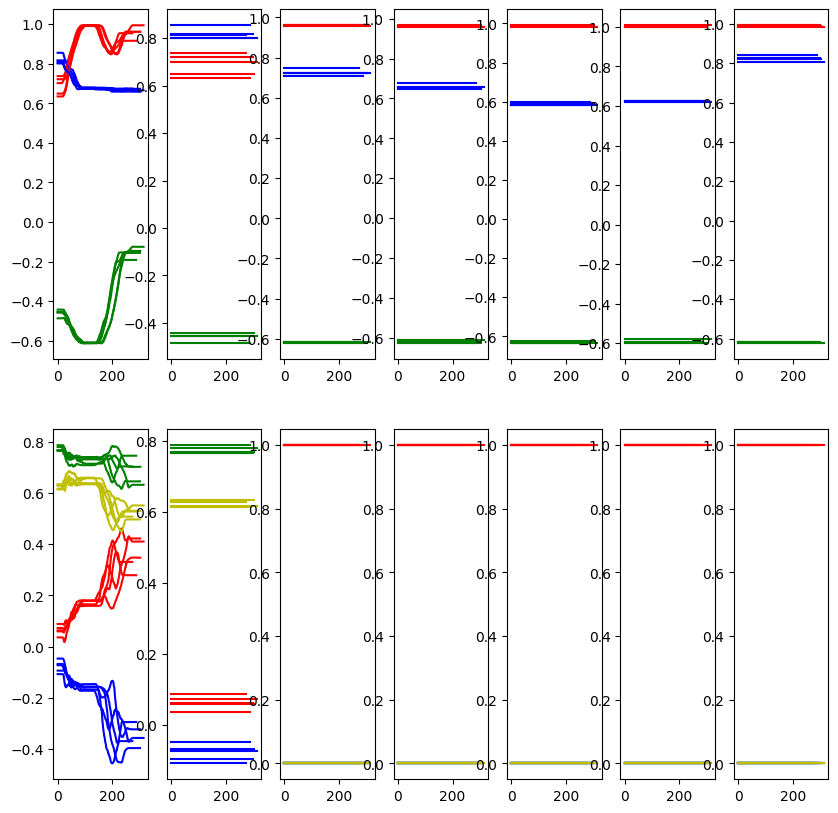

In [7]:
demos.debug_trajs()

In [8]:
tpgmm_config = TPGMMConfig(
    n_components=20,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,

    action_as_orientation=False,
    action_with_magnitude=False,

    add_gripper_action=True,

    reg_init_diag=5e-5,
    reg_diag_gripper=2e-5,
    reg_em_finish_diag_gripper=2e-5,

    reg_shrink=1e-3,
    reg_diag=5e-5,

    reg_em_finish_shrink=1e-3,
    reg_em_finish_diag=5e-5,

    fix_first_component=False,
    fix_last_component=False,

    trans_cov_mask_t_pos_corr=False,

    em_steps=1,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
)

demo_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,

    repeat_final_step=0,

    use_gripper_states=False,

    min_end_distance=35,
    min_len=4,

    velocity_threshold=0.002,
    max_idx_distance=1,
)

cascade_config = CascadeConfig(
    min_prob=0.05,
    kl_keep_rotation_dim=False
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demo_segmentation_config,
    cascade=cascade_config,
)


In [9]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2024-08-16 16:08:50.221 | INFO     |  Fitting AutoTPGMM
2024-08-16 16:08:50.221 | INFO     |  Performing fitting actions: [INIT]
2024-08-16 16:08:50.221 | INFO     |  Segmenting trajectories


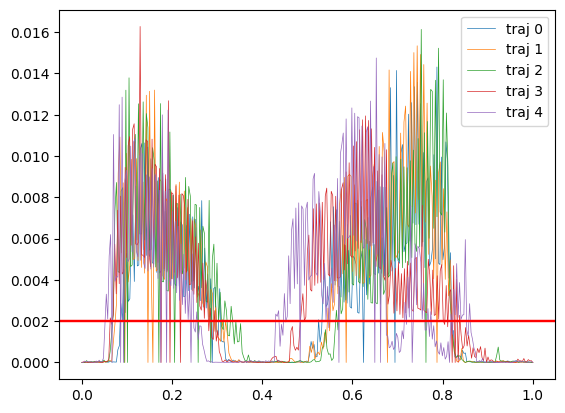

2024-08-16 16:08:50.342 | WARNING  |  Got different number of segmentation points for different trajectories.
Assuming it's because of settlement time.
Popping (tensor(218, dtype=torch.int32), tensor(250, dtype=torch.int32)) from traj 4 of len 315
2024-08-16 16:08:50.342 | INFO     |  Creating segement of demos.
2024-08-16 16:08:50.344 | INFO     |  Subsampling to length 119 using strategy mean-length.
2024-08-16 16:08:50.344 | INFO     |  Creating segement of demos.
2024-08-16 16:08:50.346 | INFO     |  Subsampling to length 177 using strategy mean-length.
2024-08-16 16:08:50.346 | INFO     |  ... created 2 segments
2024-08-16 16:08:50.346 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:08:50.346 | INFO     |    Creating partial frame view of demos.
2024-08-16 16:08:50.349 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2024-08-16 16:08:50.349 | INFO     |    Changing number of components to 10
2024-08-16 16:08:50.349 | INFO     |    Model init ...


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:08:50.674 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:08:50.675 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:08:51.010 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:08:51.010 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:08:51.345 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:08:51.346 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:08:51.700 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:08:51.700 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:08:52.062 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:08:52.062 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:08:52.558 | INFO     |  ee_init    score (rel):     -1 (1.000)
2024-08-16 16:08:52.558 | INFO     |  kp 0       score (rel):     -0 (0.195)
2024-08-16 16:08:52.558 | INFO     |  kp 1       score (rel):     -0 (0.302)
2024-08-16 16:08:52.558 | INFO     |  kp 2       score (rel):     -0 (0.285)
2024-08-16 16:08:52.559 | INFO     |  kp 3       score (rel):     -0 (0.258)
2024-08-16 16:08:52.559 | INFO     |  kp 4       score (rel):     -0 (0.320)
2024-08-16 16:08:52.559 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:08:52.560 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:08:52.560 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:08:53.084 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:08:53.084 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:08:53.642 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:08:53.642 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:08:54.218 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:08:54.218 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:08:54.736 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:08:54.737 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:08:55.231 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:08:55.231 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:08:55.785 | INFO     |  ee_init    score (rel):     -0 (0.239)
2024-08-16 16:08:55.786 | INFO     |  kp 0       score (rel):     -0 (0.595)
2024-08-16 16:08:55.786 | INFO     |  kp 1       score (rel):     -0 (0.735)
2024-08-16 16:08:55.786 | INFO     |  kp 2       score (rel):     -0 (0.989)
2024-08-16 16:08:55.786 | INFO     |  kp 3       score (rel):     -0 (1.000)
2024-08-16 16:08:55.786 | INFO     |  kp 4       score (rel):     -0 (0.712)
2024-08-16 16:08:55.786 | WARNING  |  Selected frames for segments 0 and 1 are disjoint. 
2024-08-16 16:08:55.787 | INFO     |  Adding frame 0 to segment 1.
2024-08-16 16:08:55.787 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:08:55.788 | INFO     |  Segmented trajs into 2 segments
2024-08-16 16:08:55.791 | INFO     |  Frame score (abs):
            ee_init      kp 0      kp 1      kp 2      kp 3      kp 4
Segment 0 -0.998042 -0.194371 -0.301480 -0.284417 -0.257351 -0.319607
Segment 1 -0.071253 -0.177494 -0.21926

Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:08:56.133 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

((array([[2.08e+012, 2.83e+012, 3.63e+012, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [6.43e+007, 2.16e+008, 6.70e+008, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [1.61e-007, 3.27e-006, 5.88e-005, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         ...,
         [1.02e-137, 1.16e-135, 1.23e-133, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [1.11e-278, 1.04e-274, 8.94e-271, ..., 7.76e+004, 2.99e+004,
          1.05e+004],
         [9.73e-288, 5.32e-284, 2.68e-280, ..., 5.99e+007, 4.84e+007,
          3.61e+007]]),
  array([[2.18e+61, 2.82e+61, 3.52e+61, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [5.31e+53, 1.95e+54, 6.77e+54, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.56e+17, 3.42e+19, 6.46e+21, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.53e+38, 4.25e+37, 1.13e+37],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 2.59e+53, 1.37e+53, 7.03e+52],
         [0.00e+00, 0.00e+00, 0.00e+00

In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2024-08-16 16:08:58.486 | INFO     |  Fitting AutoTPGMM
2024-08-16 16:08:58.487 | INFO     |  Segmenting trajectories


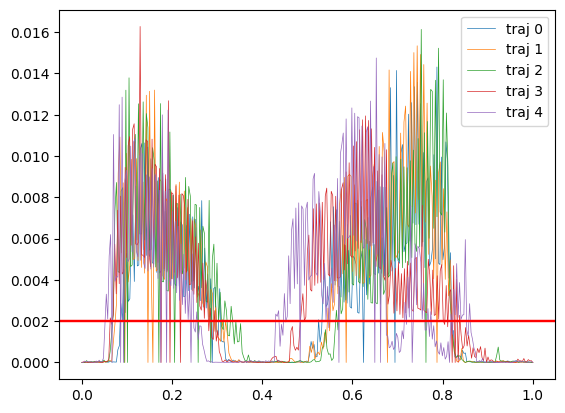

2024-08-16 16:08:58.606 | INFO     |  Creating segement of demos.
2024-08-16 16:08:58.608 | INFO     |  Creating segement of demos.
2024-08-16 16:08:58.610 | INFO     |  ... created 2 segments
2024-08-16 16:08:58.610 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:08:58.610 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:08:58.933 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:08:58.934 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:08:59.305 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:08:59.305 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:08:59.658 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:08:59.658 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:08:59.989 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:08:59.989 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:09:00.324 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:09:00.325 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:09:00.659 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:09:00.660 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:09:00.661 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:09:01.225 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:09:01.225 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:09:01.771 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:09:01.772 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:09:02.314 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:09:02.314 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:09:02.887 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:09:02.887 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:09:03.460 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:09:03.461 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:09:04.003 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:09:04.078 | INFO     |  Segmented trajs into 2 segments
2024-08-16 16:09:04.080 | INFO     |  Frame score (abs):
            ee_init      kp 0      kp 1      kp 2      kp 3      kp 4
Segment 0 -0.998042 -0.194371 -0.301480 -0.284417 -0.257351 -0.319607
Segment 1 -0.071253 -0.177494 -0.219269 -0.295150 -0.298500 -0.212502
2024-08-16 16:09:04.081 | INFO     |  Frame score (rel):
            ee_init      kp 0      kp 1      kp 2      kp 3      kp 4
Segment 0  1.000000  0.194752  0.302072  0.284975  0.257856  0.320233
Segment 1  0.238705  0.594619  0.734569  0.988777  1.000000  0.711898


Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

((array([[2.08e+012, 2.83e+012, 3.63e+012, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [6.43e+007, 2.16e+008, 6.70e+008, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [1.61e-007, 3.27e-006, 5.88e-005, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         ...,
         [1.02e-137, 1.16e-135, 1.23e-133, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [1.11e-278, 1.04e-274, 8.94e-271, ..., 7.76e+004, 2.99e+004,
          1.05e+004],
         [9.73e-288, 5.32e-284, 2.68e-280, ..., 5.99e+007, 4.84e+007,
          3.61e+007]]),
  array([[2.18e+61, 2.82e+61, 3.52e+61, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [5.31e+53, 1.95e+54, 6.77e+54, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.56e+17, 3.42e+19, 6.46e+21, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.53e+38, 4.25e+37, 1.13e+37],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 2.59e+53, 1.37e+53, 7.03e+52],
         [0.00e+00, 0.00e+00, 0.00e+00

In [11]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


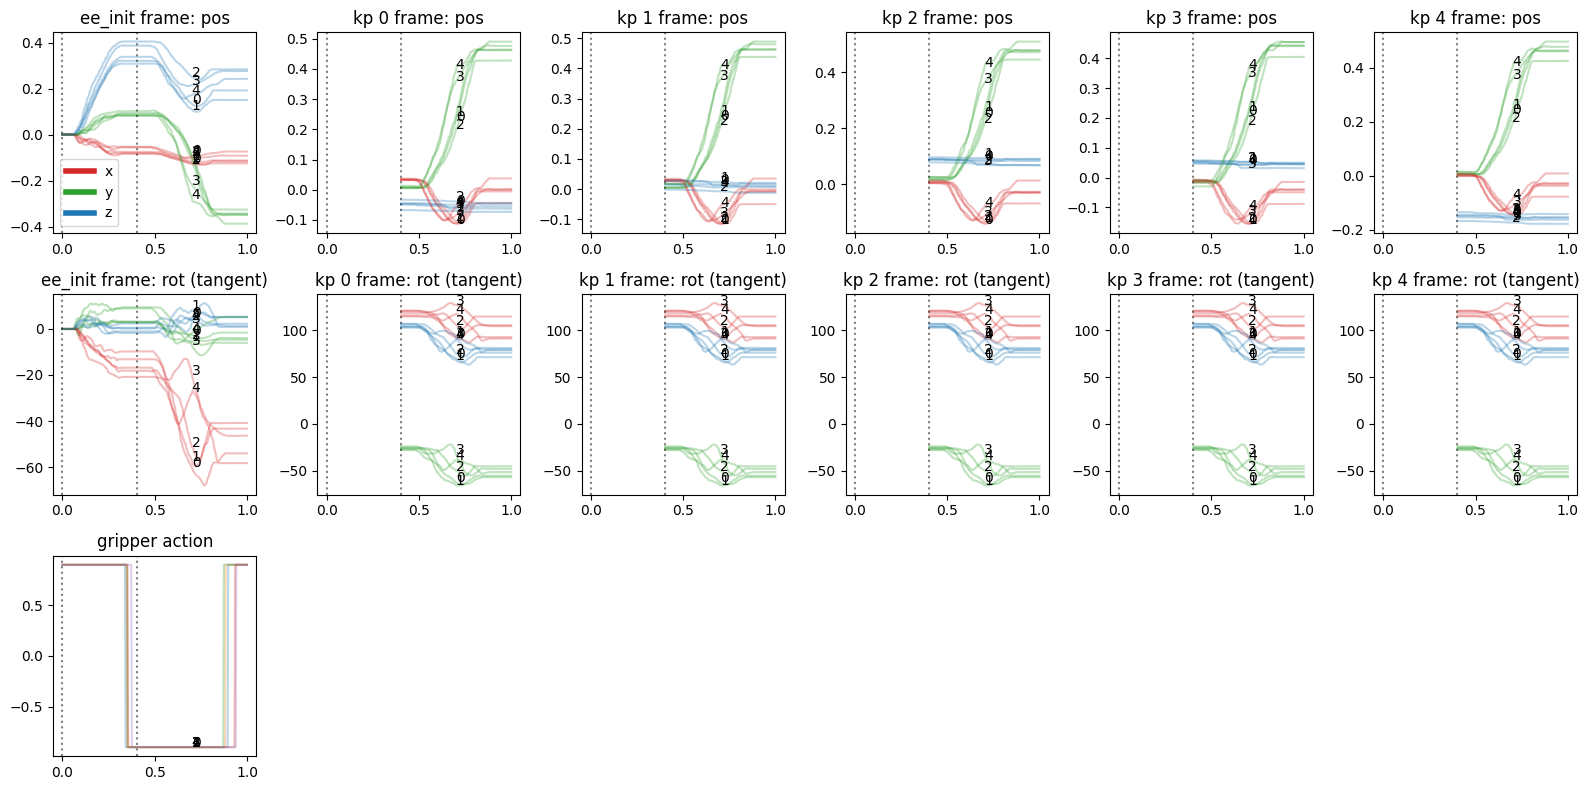

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, time_based=True,)


In [13]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.EM_HMM,))


2024-08-16 16:09:08.389 | INFO     |  Fitting AutoTPGMM
2024-08-16 16:09:08.389 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-16 16:09:08.397 | INFO     |  HMM EM ...
2024-08-16 16:09:08.401 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-16 16:09:08.483 | INFO     |  HMM init priors not defined, initializing to uniform
2024-08-16 16:09:09.705 | WARNING  |  HMM EM did not converge


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

((array([[1.00e+000, 1.00e+000, 1.00e+000, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [3.09e-005, 7.60e-005, 1.85e-004, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [7.73e-020, 1.15e-018, 1.62e-017, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         ...,
         [4.92e-150, 4.11e-148, 3.40e-146, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [5.32e-291, 3.68e-287, 2.47e-283, ..., 1.29e-003, 6.18e-004,
          2.92e-004],
         [4.67e-300, 1.88e-296, 7.38e-293, ..., 9.99e-001, 9.99e-001,
          1.00e+000]]),
  array([[1.00e+00, 1.00e+00, 1.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [2.43e-08, 6.92e-08, 1.92e-07, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [7.17e-45, 1.21e-42, 1.83e-40, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.59e-22, 5.74e-23, 2.07e-23],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 2.68e-07, 1.86e-07, 1.28e-07],
         [0.00e+00, 0.00e+00, 0.00e+00

2024-08-16 16:09:20.842 | INFO     |  Did not specify time_based, deciding automatically.
2024-08-16 16:09:21.366 | WARNING  |  Skippig NaN Gaussians.


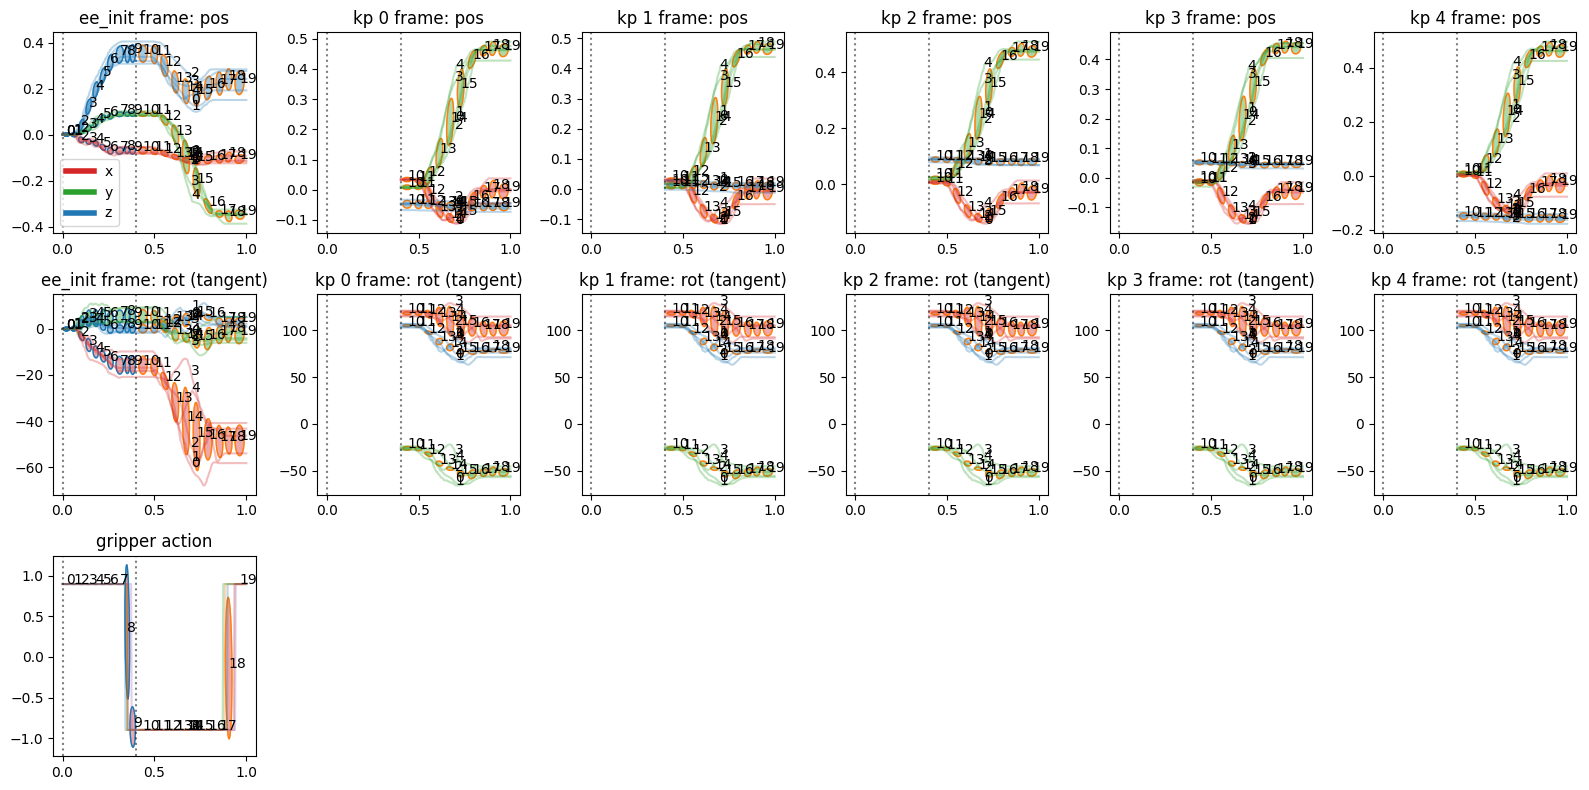

In [14]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False)


In [15]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2024-08-16 16:09:26.573 | INFO     |  Saving model:


2024-08-16 16:09:26.681 | INFO     |  Did not specify time_based, deciding automatically.


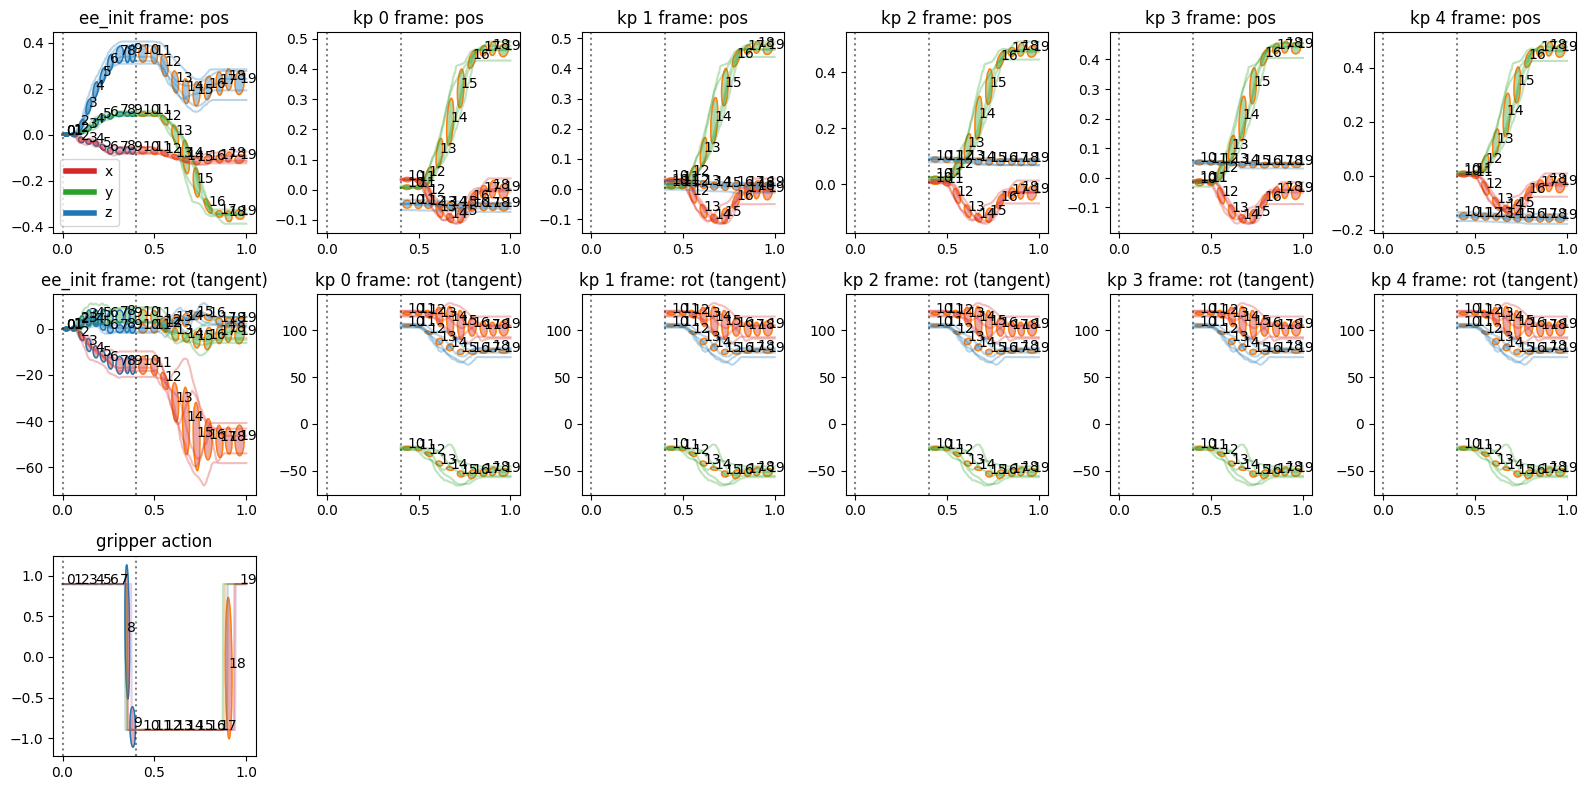

In [16]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False)


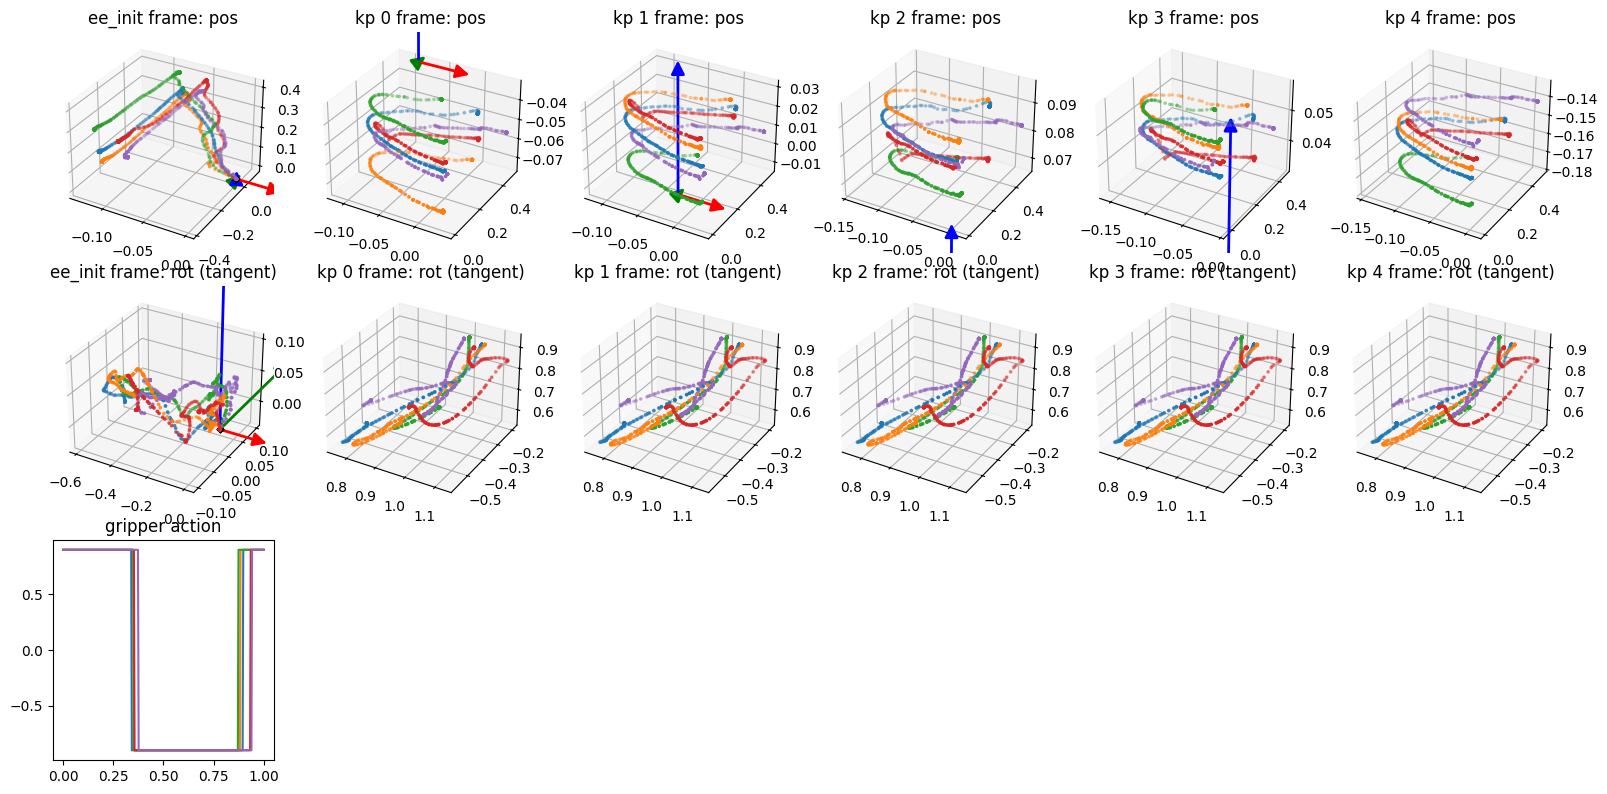

In [17]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

In [18]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2024-08-16 16:09:33.583 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2024-08-16 16:09:33.633 | INFO     |  Caculated segment transition probabilities: (array([[0.99]]),)
2024-08-16 16:09:33.633 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:09:33.636 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:09:33.691 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-16 16:09:34.186 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

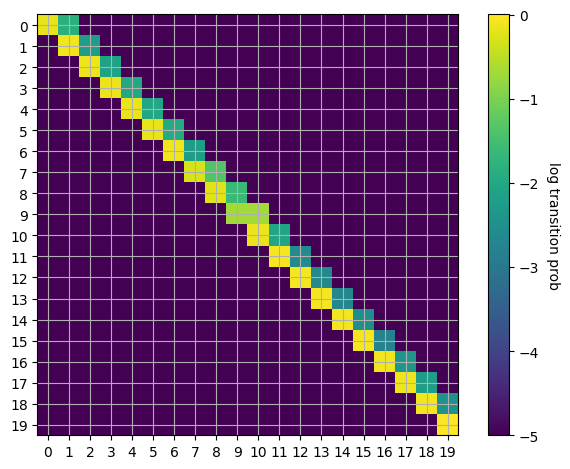

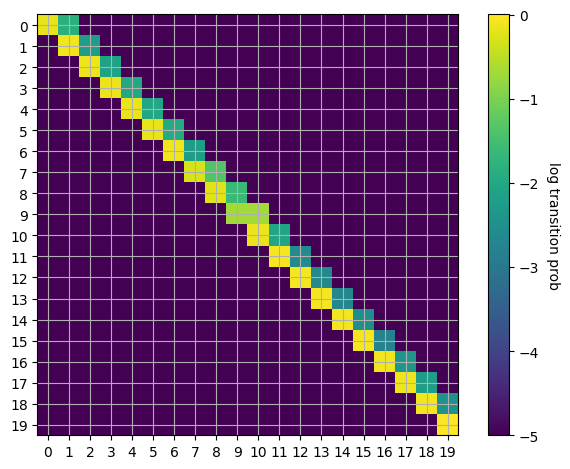

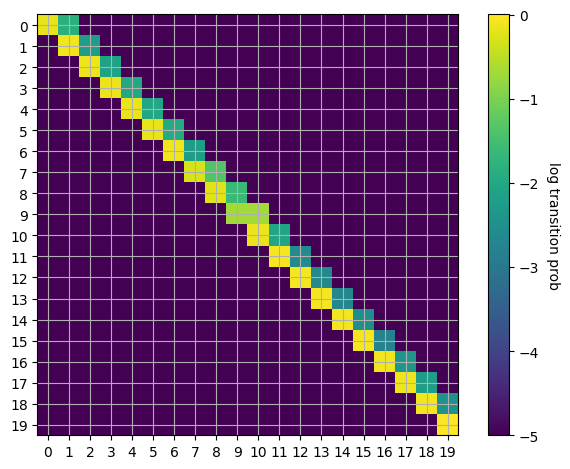

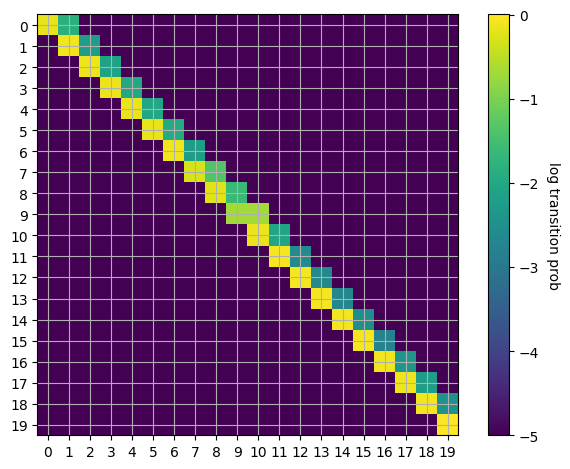

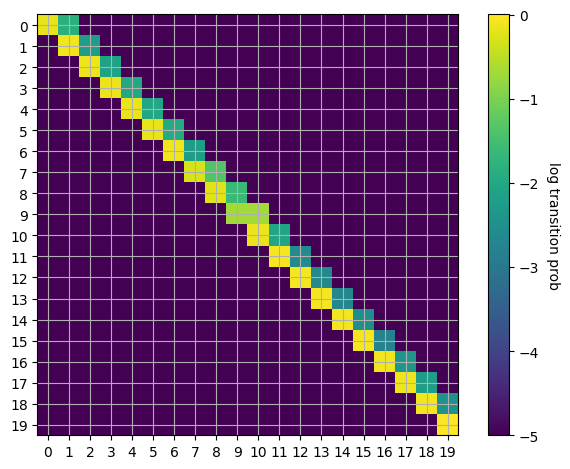

In [19]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)


2024-08-16 16:09:50.531 | INFO     |  Taking frame origins from demos.


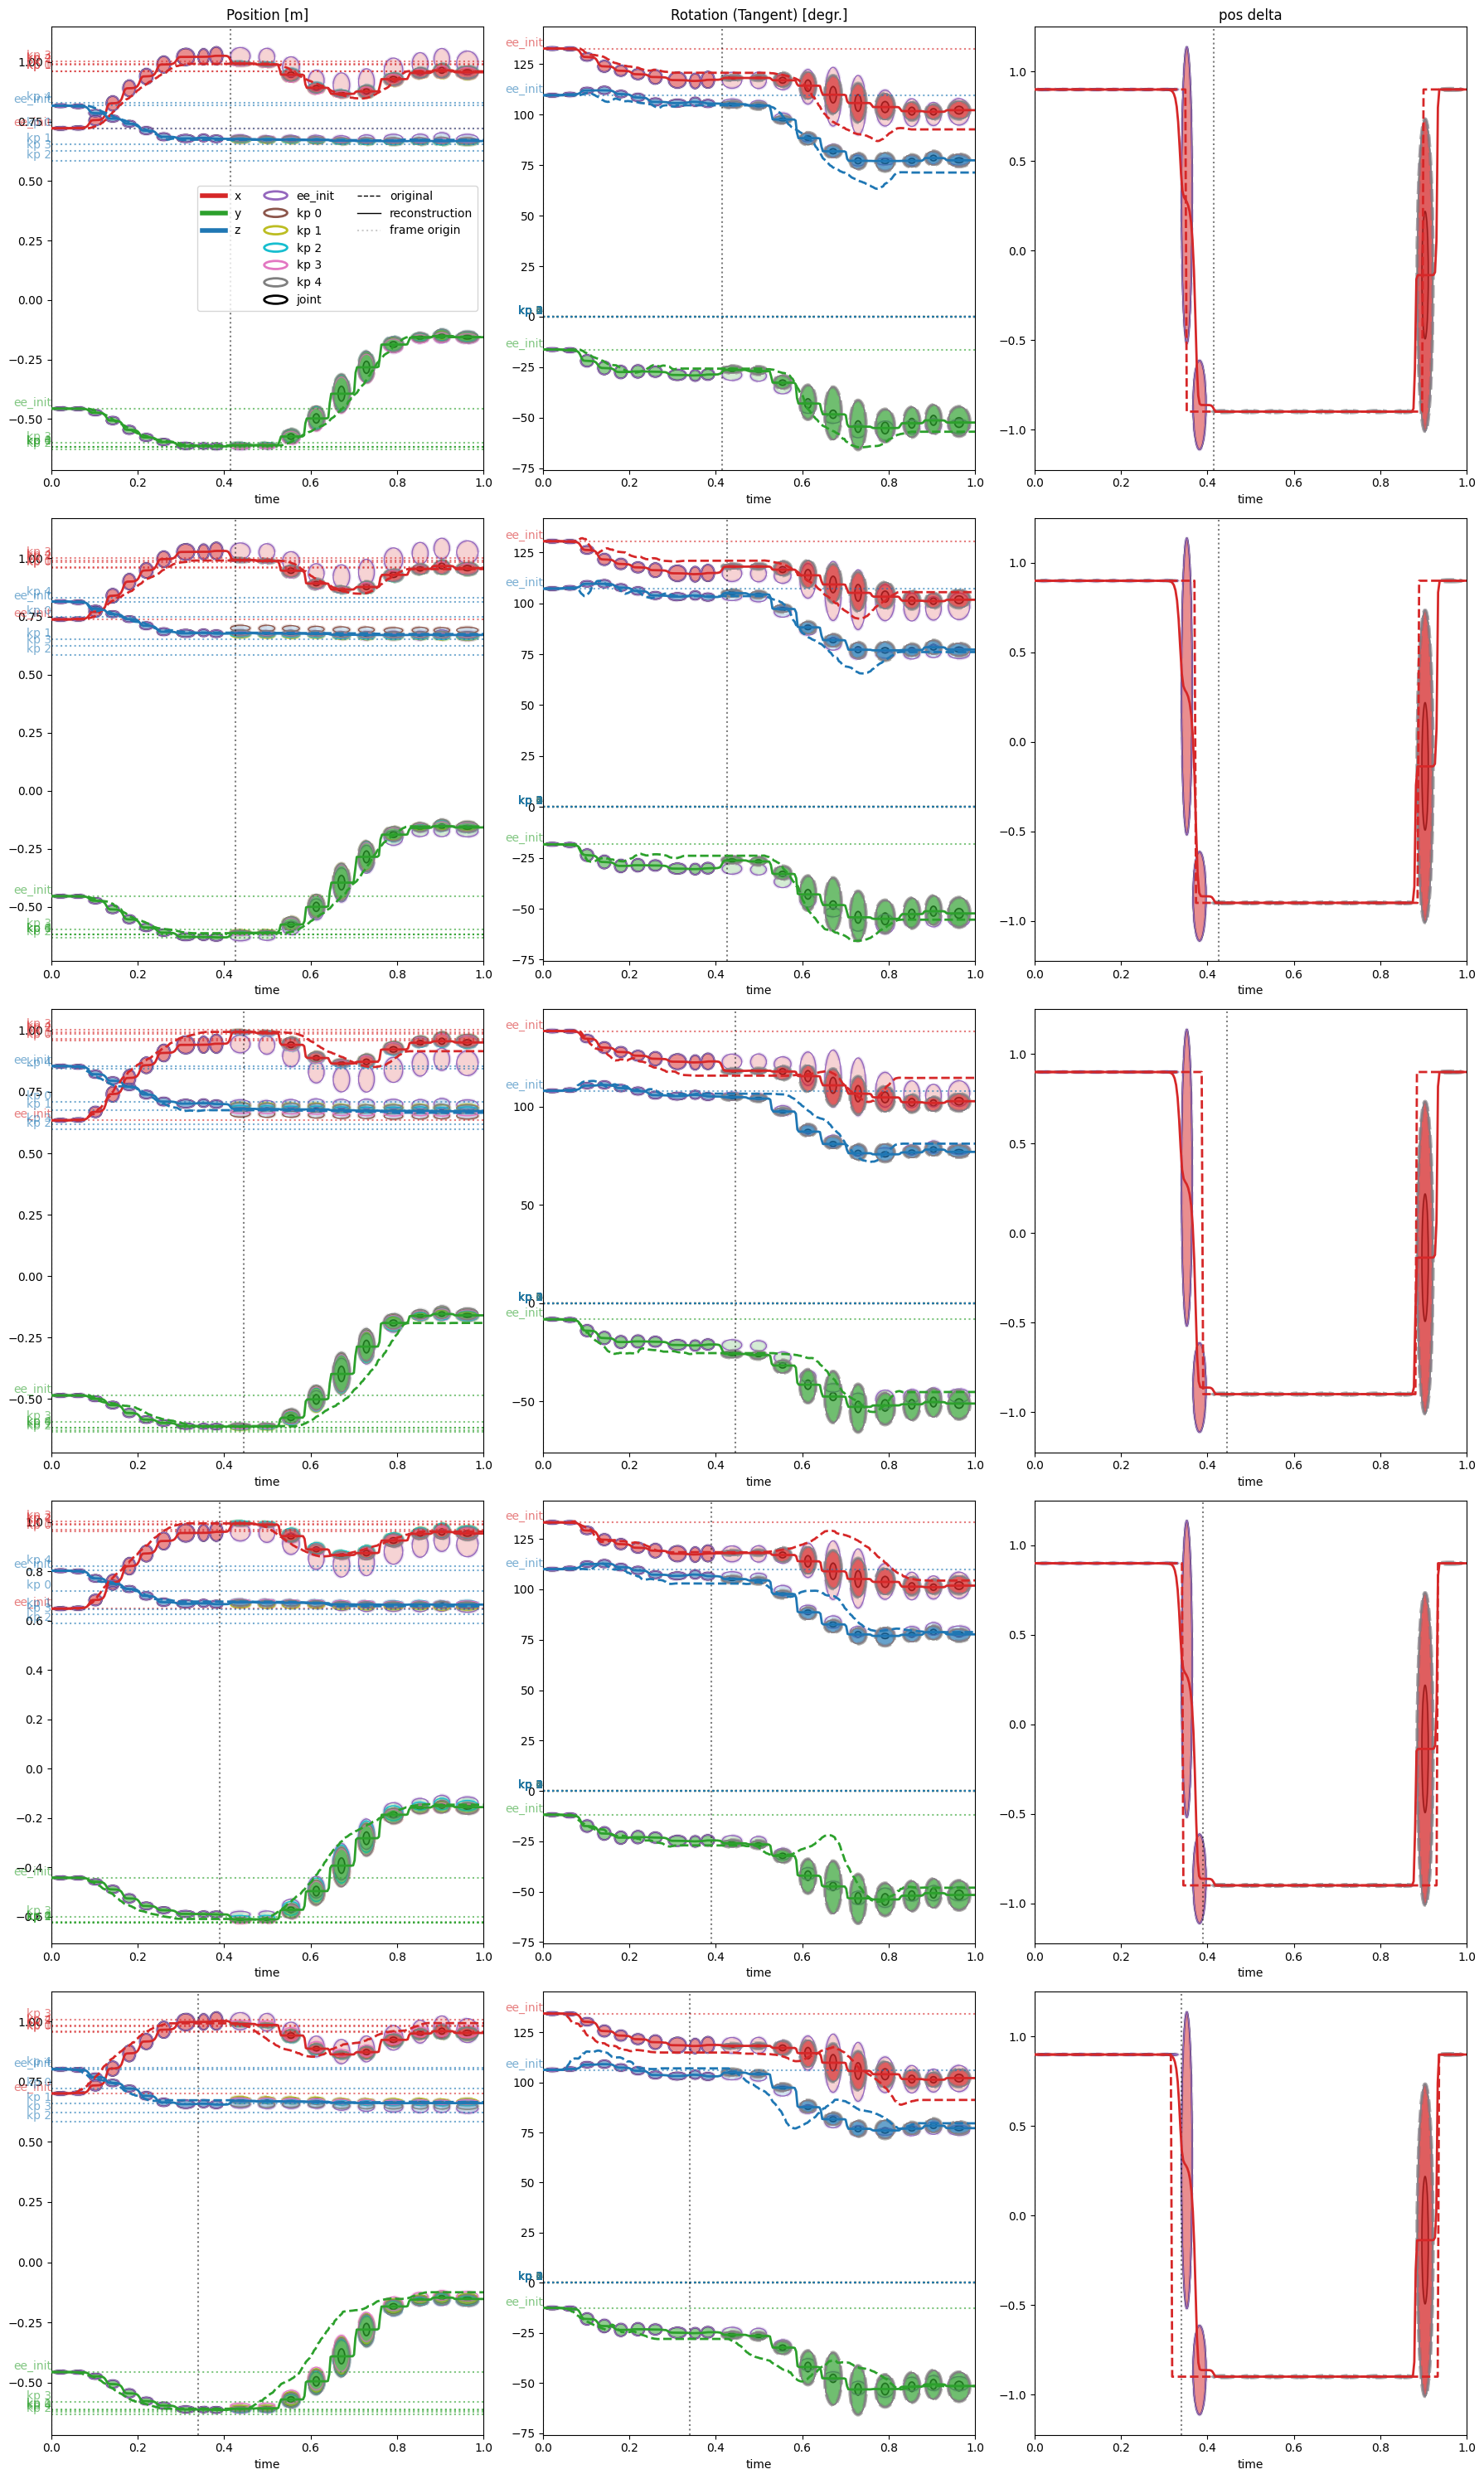

In [20]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


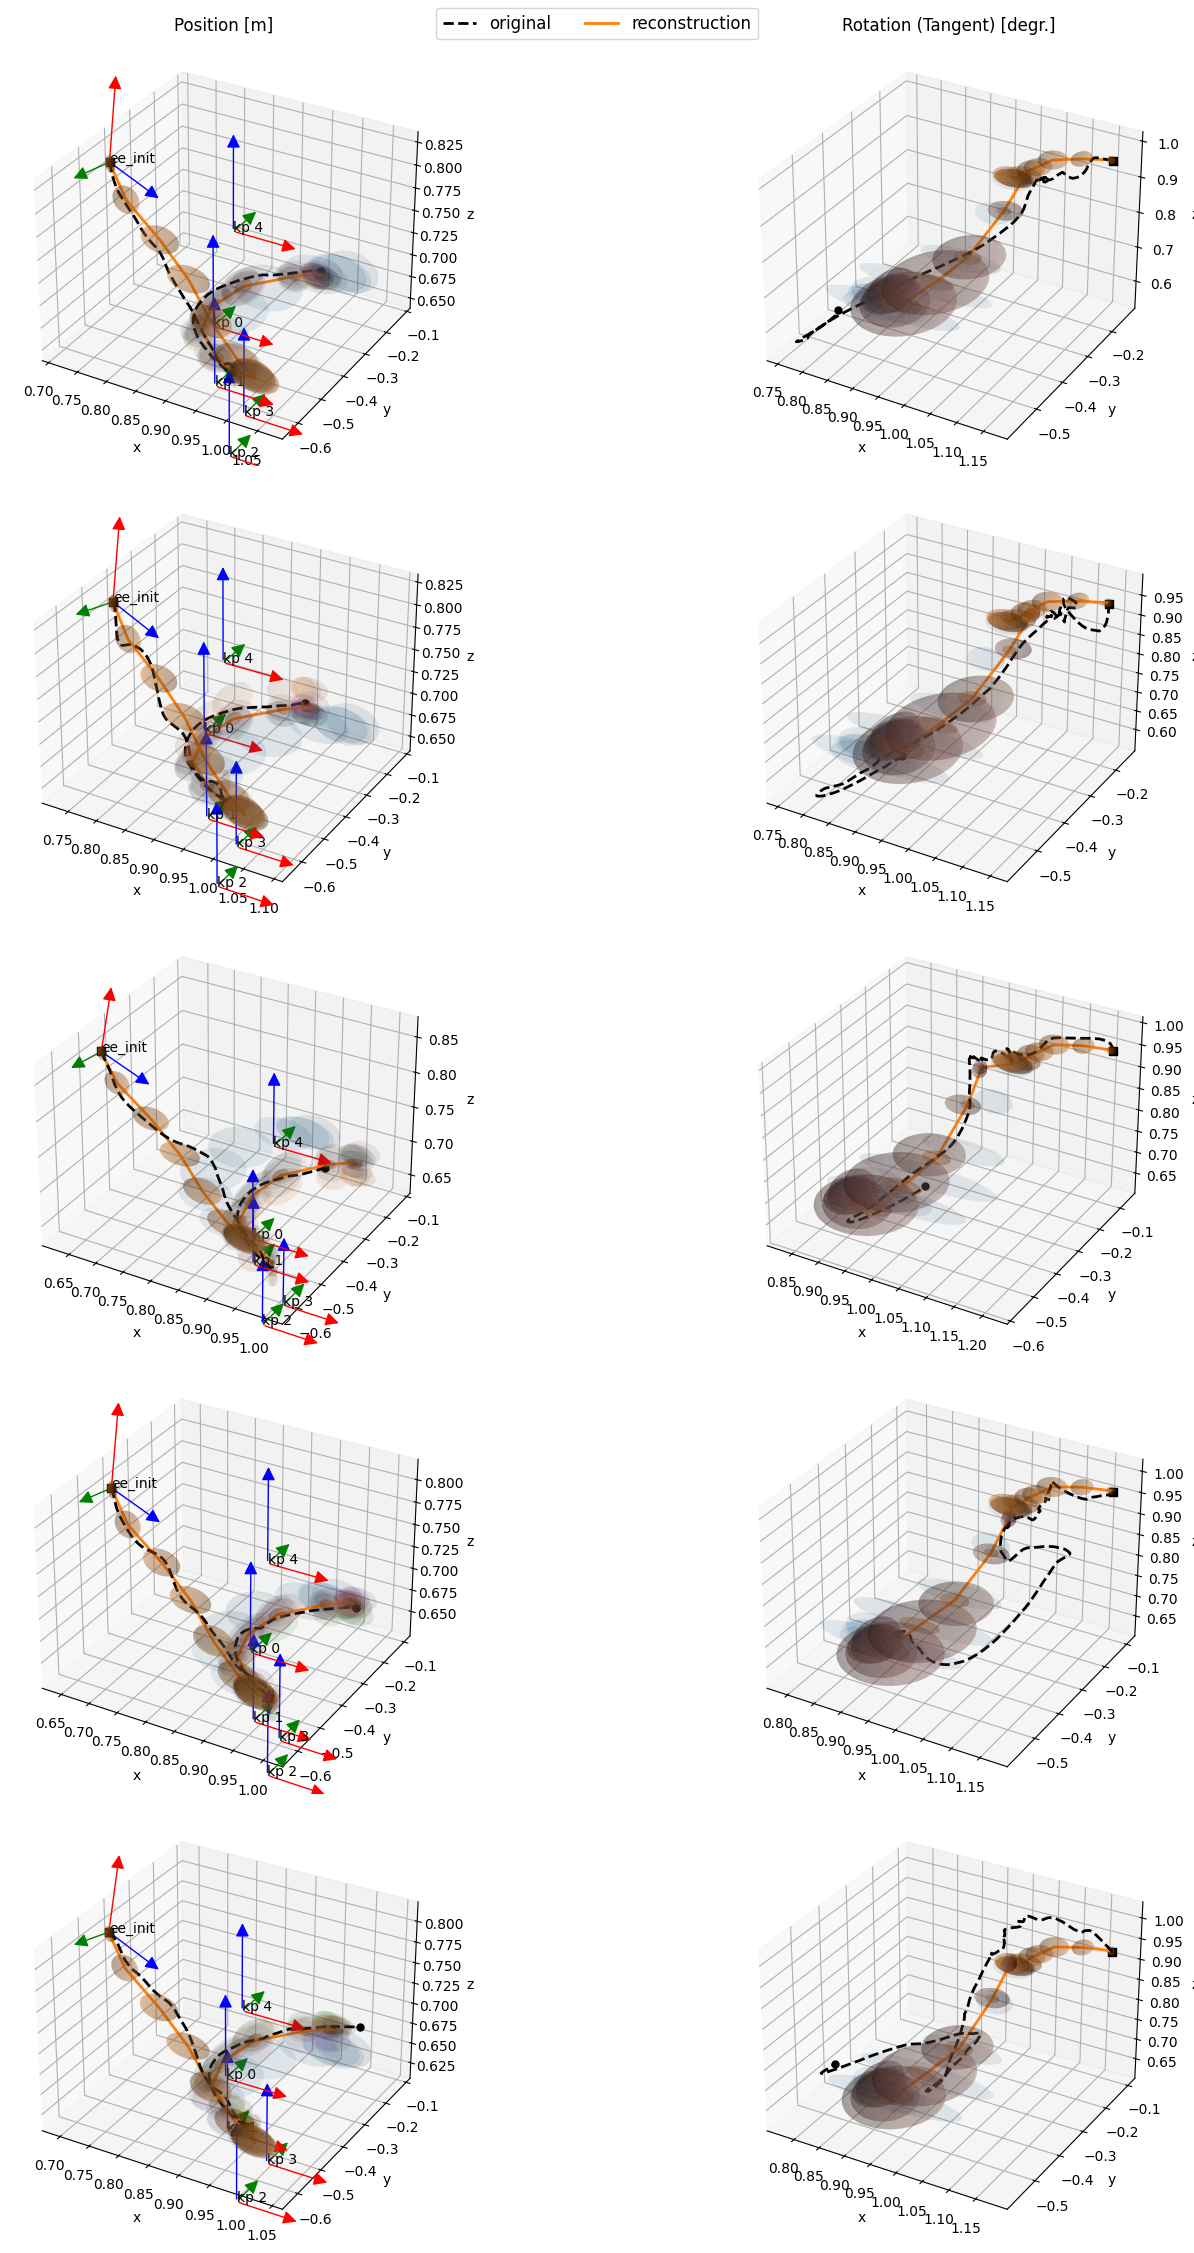

In [21]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=False, per_segment=False)